In [12]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans

In [13]:
# 1. Load pretrained YOLO model (COCO weights)
model = YOLO("yolov8n.pt")   # "n" = nano, fastest; use yolov8s.pt if you want more accuracy


In [26]:
# 2. Run detection on sample image
img_path = "../data/outfit_samples/t.jpg"
results = model(img_path, conf=0.4)


image 1/1 F:\COLLAGE-PROJECT_DEV\FR-1\notebooks\..\data\outfit_samples\t.jpg: 448x640 1 person, 1 tie, 142.7ms
Speed: 3.9ms preprocess, 142.7ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)


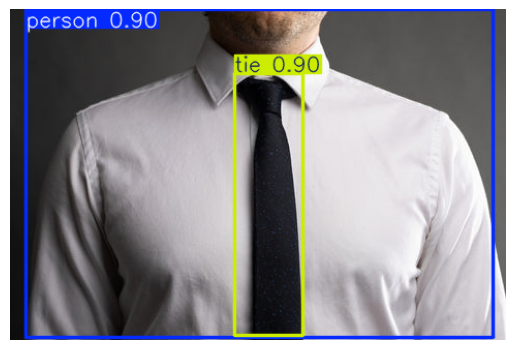

In [27]:
# 3. Plot results
res_img = results[0].plot()
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [28]:
# 4. Inspect detected classes
for r in results:
    for box in r.boxes:
        cls_id = int(box.cls[0])
        label = model.names[cls_id]
        xyxy = box.xyxy[0].tolist()
        print(f"Detected {label} at {xyxy}")

Detected tie at [217.4761962890625, 62.91704177856445, 283.9199523925781, 315.5700988769531]
Detected person at [15.69451904296875, 0.0, 467.667236328125, 317.4075622558594]


In [29]:
def get_dominant_color(pil_img, k=3):
    """Extract dominant color using k-means clustering."""
    pil_img = pil_img.convert("RGB")   # ensure 3 channels
    img = np.array(pil_img)
    img = img.reshape((-1,3))
    
    # remove pure white pixels (optional)
    img = img[~np.all(img==[255,255,255], axis=1)]
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img)
    counts = np.bincount(kmeans.labels_)
    dom_color = kmeans.cluster_centers_[counts.argmax()].astype(int)
        # mode="RGB" → shape (h,w,3) ✅
        # mode="RGBA" → shape (h,w,4) ❌
        # mode="L" (grayscale) → shape (h,w) ❌
    # print(np.array(pil_img).shape, pil_img.mode) 
    return tuple(dom_color)


# Example: crop each detection and get color
for r in results:
    for box in r.boxes:
        xyxy = [int(x) for x in box.xyxy[0]]
        crop = Image.open(img_path).crop(xyxy)
        color = get_dominant_color(crop, k=2)
        # print(f"Detected {model.names[int(box.cls[0])]} → Dominant color: {color}")
        color = tuple(map(int, color))
        print(f"Detected {model.names[int(box.cls[0])]} → Dominant color: {color}")


Detected tie → Dominant color: (28, 27, 32)
Detected person → Dominant color: (201, 196, 200)
